<a href="https://colab.research.google.com/github/ZKingQ/CS598-DLH-SP24/blob/main/DLH_Team_71_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS598 Deep Learning for Healthcare - Final Project - DeepMicro: Deep Representation Learning for Disease Prediction based on Microbiome Data

### Lotte Zhu, Kaiqing Zhang, Matthew Trueblood (Team ID: 71)
#### GitHub Link: https://github.com/ZKingQ/CS598-DLH-SP24
#### Project Video Link: https://mediaspace.illinois.edu/media/t/1_r5pnhwtj

# 1. Introduction
<!-- This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem). -->


The expanding knowledge of microbiota uncovers its crucial role in human health [1]. It plays an important role in immune system, metabolism functions and even carcinognesis of certain cancers, hence microbiota can be used to predict various disease with emerging sequencing technologies [1,2,3,4,5,6]. However, there are three major challenges to realize the predictions in practice [7]. First, the low number of samples, together with the large number of features, leads to the curse of dimensionality. Second, there is a research gap in using strain-level profiles to classify samples into patient and healthy control groups across different diseases. Third, a rigorous validation framework is essential. Prior research has shown that tuning hyperparameters on the test set without a separate validation set may lead to an overestimation of model performance [8,9,10].

The DeepMicro paper proposes the deployment of autoencoders to learn low-dimensional representations from microbiota data and then predict disease by another classification model based on the learned representations, with both trainings having thorough validation schemes [7]. The authors hypothesize that these innovations can contribute to the followings:

1. The appropriate autoencoders can effectively solve the curse of dimensionality.

2. They also reduce latency compared with alternative models without representation learing, in the mean time maintaining favorable training metrics.

In this project, our primary objective revolves around the implementation and evaluation of various autoencoder architectures. We aim to validate the disease prediction capabilities as outlined in the paper. Furthermore, we discuss the ablations inherent in the innovation of autoencoder. The rationale for choosing this paper stems from our pursuit of knowledge in deep representation learning.


# 2. Github Repository

Our project is published on [CS598-DLH-SP24](https://github.com/ZKingQ/CS598-DLH-SP24/tree/main).

# 3. Scope of Reproducibility

<!-- List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1: xxxxxxx
2.   Hypothesis 2: xxxxxxx

You can insert images in this notebook text, [see this link](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive) and example below:

![sample_image.png](https://drive.google.com/uc?export=view&id=1g2efvsRJDxTxKz-OY3loMhihrEUdBxbc)


You can also use code to display images, see the code below.

The images must be saved in Google Drive first.

-->

Our team achieved successful replication of the model by leveraging its open source codebase, resulting in metrics that are comparable to those showcased in the DeepMicro paper. In our endeavor, we thoroughly examined and addressed the claims below put forth in the original paper.

1. **Dimensionality reduction engineering with traditional statistical techniques including Principal Component Analysis (PCA) and Gaussian Random Projection (GRP)**

- Principal Component Analysis (PCA) aims to capture the most significant patterns and variations in a dataset by identifying orthogonal axes, known as principal components, that maximize the data variance.
- Gaussian Random Projection (GRP) seeks to preserve pairwise distances between data points by projecting them onto a lower-dimensional space using random projections drawn from a Gaussian distribution.

2. **Innovated representation learning employing with four different autoencoders including Shallow Autoencoder (SAE), Deep Autoencoder (DAE), Variational Autoencoder (VAE), and Convolutional Autoencoder (CAE)**

- Shallow Autoencoder (SAE): This is the simplest form of an autoencoder, consisting of a fully
connected encoder layer and a decoder layer. The latent representation is obtained from the encoder
layer, which is a lower-dimensional space compared to the original input.
- Deep Autoencoder (DAE): In addition to the encoder and decoder layers, DAE introduces hidden
layers between the input and latent layers and between the latent and output layers. Rectified Linear
Unit (ReLU) activation functions are used in the hidden layers.
- Variational Autoencoder (VAE): VAE learns probabilistic representations by approximating the
true posterior distribution of latent embeddings. It assumes that the posterior distribution follows
a Gaussian distribution. VAE uses an encoder network to encode the means and variances of the
Gaussian distribution and samples the latent representation from this distribution. The decoder
network then reconstructs the input based on the sampled latent representation.
- Convolutional Autoencoder (CAE): Instead of fully connected layers, CAE incorporates convo-
lutional layers, where each unit is connected to local regions of the previous layer. Convolutional layers use filters (kernels) to perform convolution operations. CAE employs convolutional transpose layers (deconvolutional layers) to make the decoder symmetric to the encoder. No pooling layers
are used in CAE.

3. **Classification learning including including Support Vector Machine (SVM), Random Forest (RF), and Multi-Layer Perceptron (MLP)**
- Support Vector Machine (SVM) is a supervised learning algorithm that aims to find an optimal hyperplane to classify data by maximizing the margin between different classes.
- Random Forest (RF) is an ensemble learning method that constructs a multitude of decision trees and combines their predictions to make classifications.
- Multi-Layer Perceptron (MLP) is a type of neural network that consists of multiple layers of interconnected nodes, enabling it to learn non-linear relationships and perform classification tasks.


# 4. Methodology

<!-- This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment. -->

## 4.1. Environment

### 4.1.1. Python Version

We use colab default python environment which is `python==3.10.12`.

In [1]:
# Python version
!python --version

Python 3.10.12


### 4.1.2. Packages

We utilize PyTorch to build our models so this project primarily depends on `sklearn` and `pytorch`.

In [2]:
# import packages needed in this project
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib
matplotlib.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# importing PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

##  4.2. Data
<!-- Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset. -->

### 4.2.1 Data Download Instruction

We store two datasets, abundance and marker from the [DeepMicro codebase](https://github.com/minoh0201/DeepMicro/tree/master/data) in the path `raw_data_dir` of the [colab project](https://drive.google.com/file/d/1c6ZPVp346e1wQH6opg4YwlCRjRgfTXCk/view?usp=drive_link).

When we run this project locally, we use the function `fetch_data_from_remote` to download the datasets from the google drive to current working directory.

In [3]:
# data dir
raw_data_dir = 'data/'

# Load data
import os
import requests
from zipfile import ZipFile
from io import BytesIO

def fetch_data_from_remote():
    # cloud location where the .zip file of the data used by this project is stored
    url = 'https://drive.google.com/file/d/1c6ZPVp346e1wQH6opg4YwlCRjRgfTXCk/view?usp=drive_link'

    file_id = url.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?export=download&id=' + file_id

    # unzip the data into the local working directory
    response = requests.get(dwn_url)
    zip_content = BytesIO(response.content)
    with ZipFile(zip_content, 'r') as main_zip:
        main_zip.extractall()
        with main_zip.open('data/abundance.zip') as nested_zip_abundance:
            with ZipFile(nested_zip_abundance) as zip_ref_abundance:
                zip_ref_abundance.extractall('data/abundance')

        with main_zip.open('data/marker.zip') as nested_zip_marker:
            with ZipFile(nested_zip_marker) as zip_ref_marker:
                zip_ref_marker.extractall('data/marker')

if os.path.exists('data'):
    print("Data already exists locally")
else:
    fetch_data_from_remote()
    print("Data fetched and unzipped successfully")

# show that the data is available locally now
!ls data/abundance/
!ls data/marker/

Data already exists locally
abundance_Cirrhosis.txt   abundance_IBD.txt	 abundance_T2D.txt
abundance_Colorectal.txt  abundance_Obesity.txt  abundance_WT2D.txt
marker_Cirrhosis.txt   marker_IBD.txt	   marker_T2D.txt
marker_Colorectal.txt  marker_Obesity.txt  marker_WT2D.txt


### 4.2.2. Data Description

Our reproductivity utilizes the same datasets as the original paper, which include six disease (Table 1). They are inflammatory bowel disease (IBD), type 2 diabetes in European women (EW-T2D), type 2 diabetes in Chinese (C-T2D), obesity (Obesity), liver cirrhosis (Cirrhosis), and colorectal cancer (Colorectal).

![](https://github.com/ZKingQ/CS598-DLH-SP24/blob/main/assets/Data_Table1.png?raw=1)

In each dataset, marker profile and abundance profile of microbiome are used to train our models (Table 2).

![](https://github.com/ZKingQ/CS598-DLH-SP24/blob/main/assets/Data_Table2.png?raw=1)

All the data are stored in txt format and the data path structure is as following.

```
.
├── ...
├── data                              # Data folder
│   ├── marker                        # Marker profile data
│       ├── marker_IBD.txt            # Inflammatory bowel disease (IBD)
│       ├── marker_WT2D.txt           # Type 2 diabetes in European women (EW-T2D)
│       ├── marker_T2D.txt            # Type 2 diabetes in Chinese (C-T2D)
│       ├── marker_Obesity.txt        # Obesity (Obesity)
│       ├── marker_Cirrhosis.txt      # Liver cirrhosis (Cirrhosis)
│       ├── marker_Colorectal.txt     # Colorectal cancer (Colorectal)
│   ├── abundance                     # Abundance profile data
│       ├── abundance_IBD.txt         # Inflammatory bowel disease (IBD)
│       ├── abundance_WT2D.txt        # Type 2 diabetes in European women (EW-T2D)
│       ├── abundance_T2D.txt         # Type 2 diabetes in Chinese (C-T2D)
│       ├── abundance_Obesity.txt     # Obesity (Obesity)
│       ├── abundance_Cirrhosis.txt   # Liver cirrhosis (Cirrhosis)
│       ├── abundance_Colorectal.txt  # Colorectal cancer (Colorectal)
└── ...
```
In each txt file, it has different number of features and data points as shown in Table 1 and Table 2 above. In the sample demonstration and visualizations below. The colorectal cancer of microbiome abundance profile has 503 features (exluding those dummy labels) and 121 entries.



In [4]:
# Extract a sample data of colorectal cancer of microbiome abundance profile
sample = pd.read_csv(os.path.join(raw_data_dir, "abundance", "abundance_Colorectal.txt"), sep='\t', index_col=0, header=None)
sample = sample.T
sample.head(10)

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,...,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Eremothecium|s__Eremothecium_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_antri,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1
1,Zeller_fecal_colorectal_cancer,CCIS00146684ST-4-0,fr-726,stool,n,72,female,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0
2,Zeller_fecal_colorectal_cancer,CCIS00281083ST-3-0,fr-060,stool,n,53,male,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0
3,Zeller_fecal_colorectal_cancer,CCIS02124300ST-4-0,fr-568,stool,n,35,male,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0
4,Zeller_fecal_colorectal_cancer,CCIS02379307ST-4-0,fr-828,stool,cancer,67,male,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0
5,Zeller_fecal_colorectal_cancer,CCIS03473770ST-4-0,fr-192,stool,n,29,male,france,Illumina,25432777,...,0,0,0,0,0,0,0.03756,0,0,0
6,Zeller_fecal_colorectal_cancer,CCIS06260551ST-3-0,fr-200,stool,cancer,58,male,france,Illumina,25432777,...,0,0,0.31121,0,0.03562,0,0,0,0,0
7,Zeller_fecal_colorectal_cancer,CCIS07539127ST-4-0,fr-460,stool,n,77,female,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0
8,Zeller_fecal_colorectal_cancer,CCIS07648107ST-4-0,fr-053,stool,n,62,female,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0
9,Zeller_fecal_colorectal_cancer,CCIS08668806ST-3-0,fr-214,stool,small_adenoma,63,male,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0
10,Zeller_fecal_colorectal_cancer,CCIS09568613ST-4-0,fr-400,stool,n,67,male,france,Illumina,25432777,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Count the features excluding patients information
len([ _ for _ in sample.columns if '|' in _ ])

503

In [6]:
# Calculate the dimensions of the sameple dataset
sample.shape

(121, 714)

In [7]:
# Have a generate descrption of the sample dataset
sample.describe().T

,count,unique,top,freq
0,,,,
dataset_name,121,1,Zeller_fecal_colorectal_cancer,121
sampleID,121,121,CCIS98832363ST-4-0,1
subjectID,121,121,fr-552,1
bodysite,121,1,stool,121
disease,121,3,cancer,48
...,...,...,...,...
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri,121,2,0,120
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus,121,5,0,117
k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,121,2,0,120


### 4.2.3. Data Preprocess

According to the original paper, the original data provided in the codebase have been preprocessed and cleaned properly. However, we still need to identify the features columns and labels to extract `X` and `Y`, respectively.

In abundance data, we extradct features by `k__`. In marker data, the features are chracterized with `gi|`.

For labels of different deseases, we created an dictionary `label_dict` to make the labels into binary numbers (i.e. either 1 or 0).

In [8]:
# define random seed
seed = 42

label_dict = {
    # Controls
    'n': 0,
    # Chirrhosis
    'cirrhosis': 1,
    # Colorectal Cancer
    'cancer': 1, 'small_adenoma': 0,
    # IBD
    'ibd_ulcerative_colitis': 1, 'ibd_crohn_disease': 1,
    # T2D and WT2D
    't2d': 1,
    # Obesity
    'leaness': 0, 'obesity': 1,
}


def load_data(data_dir, filename, dtype=None):
    feature_string = ''
    if filename.split('_')[0] == 'abundance':
        feature_string = "k__"
    if filename.split('_')[0] == 'marker':
        feature_string = "gi|"
    # read file
    filename = data_dir + filename
    if not os.path.isfile(filename):
        print("FileNotFoundError: File {} does not exist".format(filename))
        exit()
    raw = pd.read_csv(filename, sep='\t', index_col=0, header=None)

    # select rows having feature index identifier string
    X = raw.loc[raw.index.str.contains(feature_string, regex=False)].T

    # get class labels
    Y = raw.loc['disease']
    Y = Y.replace(label_dict)

    # train and test split
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(dtype), Y.values.astype('int'), test_size=0.2,
        random_state=seed, stratify=Y.values
        )
    print("Train data shape: ", X_train.shape)
    print("Test data shape: ", X_test.shape)
    return X_train, X_test, y_train, y_test

##   4.3. Model

### 4.3.1. Citation to the Original Paper

Oh, M., & Zhang, L. (2020). DeepMicro: deep representation learning for disease prediction based on microbiome data. Scientific reports, 10(1), 6026.

### 4.3.2. Link to the Original Paper's Repo
[DeepMicro Github Repository](https://github.com/minoh0201/DeepMicro)

### 4.3.3. Model Descriptions

An autoencoder represents a type of neural network designed for the purpose of reconstructing its input data, denoted as $x$. In its fundamental structure, it comprises an encoder function, denoted as $f_\phi(⋅)$, and a decoder function, denoted as $f_\theta′(⋅)$, with $\phi$ and $\theta$ serving as the parameters associated with the encoder and decoder functions, respectively.
The training objective of an autoencoder is to minimize the disparity between the original input $x$ and its reconstructed counterpart $x′$. This discrepancy, typically quantified using a reconstruction loss metric such as squared error, can be mathematically expressed as $L(x, x')=||x-x'||^2=||x-f_\theta'(f_\phi(x))||^2$.

In this project, we focus on the utilization of a trained autoencoder to obtain a lower-dimensional latent representation $z = f_\phi(x)$ of the input. There are four autoencoders that we incorporate as below.

1. Shallow Autoencoder (SAE): a fully connected encoder connecting the input layer to the latent layer, and a decoder producing the reconstructed input $x′$ by combining the outputs of the latent layer using weighted sums, with both the latent and output layers utilizing a linear activation function.

2. Deep Autoencoder (DAE): enhanced SAE model by inserting hidden layers with Rectified Linear Unit (ReLu) activation function and Glorot uniform initializer between the input and latent layers, maintaining an equal number of hidden layers (either one or two layers) in both the encoder and decoder sections.

3. Variational autoencoder (VAE): it learns probabilistic representations $z$ by approximating the true posterior distribution with $q_\phi(z|x)$ assuming a Gaussian distribution. The encoder encodes the means and variances of the Gaussian distribution, allowing sampling of latent representation $z$. This sampled representation is then fed into the decoder network to generate the reconstructed input $x′ \sim g_\theta(x|z)$.

4. convolutional autoencoder (CAE): equipped with convolutional layers where each unit is connected locally to the previous layer. The layers consist of multiple filters with weights for convolution operations. We employed ReLu activation, Glorot uniform initializer, and avoided pooling layers to prevent excessive generalization. The $n$-dimensional input vector was reshaped into a squared image of size $d \times d \times 1$, where $d = ⌊ \sqrt{n} ⌋ + 1$.

After getting the low-dimentional representations of profiles, we build classification models.

1. Support Vector Machine (SVM): a grid search using SVM is conducted to explore the hyper-parameter space. We considered both radial basis function (RBF) and linear kernels, adjusting penalty parameter C and kernel coefficient gamma for RBF.

2. Random Forest (RF): We examine two criteria, Gini impurity and information gain, for selecting features to split a node in a decision tree. The maximum number of features considered for the best split at each node was determined using the square root of the sample size and the logarithm to base 2 of the sample size.

3. Multi-Layer Perceptron (MLP): ReLu activations were used for the hidden layers, while the output layer employed sigmoid activation with a single unit. The number of units in the hidden layers was set to half of the preceding layer, excluding the first hidden layer.

The overall workflow is demonstrated in the Figure 1 below.

![](https://github.com/ZKingQ/CS598-DLH-SP24/blob/main/assets/Model_Figure1.png?raw=1)

### 4.3.4. Implementation Code

Please find the implementations of autoencoders in the section [Autoencoders Definitions](#autoencoders-definitions) below.

#### Autoencoders Definitions



In [9]:
class EarlyStopper:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0

        return self.early_stop


class ShallowAutoEncoder(nn.Module):
    def __init__(self, input_dim=28 * 28):
        super(ShallowAutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.encoder1 = nn.Linear(input_dim, 32)
        self.decoder1 = nn.Linear(32, input_dim)

    def encoder(self, x):
        return torch.tanh(self.encoder1(x))

    def decoder(self, z):
        return torch.sigmoid(self.decoder1(z))

    def forward(self, x):
        z = self.encoder(x.view(-1, self.input_dim))
        return self.decoder(z)

    @staticmethod
    def loss_func(x_hat, x):
        return F.mse_loss(x_hat, x, reduction='sum')


class AutoEncoder(nn.Module):
    def __init__(self, input_dim=28*28):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim

        # DNN as encoder
        # 512-256-128
        self.encoder1 = nn.Linear(input_dim, 512)
        self.encoder2 = nn.Linear(512, 256)
        self.encoder3 = nn.Linear(256, 128)

        # DNN as decoder
        self.decoder1 = nn.Linear(128, 256)
        self.decoder2 = nn.Linear(256, 512)
        self.decoder3 = nn.Linear(512, input_dim)

    def encoder(self, x):
        h = torch.tanh(self.encoder1(x))
        h = torch.tanh(self.encoder2(h))
        return torch.tanh(self.encoder3(h))

    def decoder(self, z):
        h = torch.tanh(self.decoder1(z))
        h = torch.tanh(self.decoder2(h))
        return torch.sigmoid(self.decoder3(h))

    def forward(self, x):
        z = self.encoder(x.view(-1, self.input_dim))
        return self.decoder(z)

    @staticmethod
    def loss_func(x_hat, x):
        return F.mse_loss(x_hat, x)


class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        # CNN as encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 6)
        )

        # CNN as decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 6),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    @staticmethod
    def loss_func(x_hat, x):
        return F.mse_loss(x_hat, x)


class VAE(nn.Module):
    def __init__(self, input_dim=28 * 28, latent_dim=8):
        super(VAE, self).__init__()
        self.input_dim = input_dim

        # DNN as encoder
        self.encoder1 = nn.Linear(input_dim, 128)
        self.mu = nn.Linear(128, 8)
        self.log_sigma2 = nn.Linear(128, 8)

        # DNN as decoder
        self.decoder1 = nn.Linear(8, 128)
        self.decoder2 = nn.Linear(128, input_dim)

    def encoder(self, x):
        h = torch.tanh(self.encoder1(x))
        return self.mu(h), torch.sqrt(torch.exp(self.log_sigma2(h)))

    @staticmethod
    def sampling(mu, std):  # Re parameterization trick
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = torch.tanh(self.decoder1(z))
        return torch.sigmoid(self.decoder2(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, self.input_dim))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

    @staticmethod
    def loss_func(x_hat, x, mu, std):
        # define the reconstruction loss
        ERR = F.binary_cross_entropy(x_hat, x, reduction='sum')
        # define the KL divergence loss
        KLD = -0.5 * torch.sum(1 + torch.log(std ** 2) - mu ** 2 - std ** 2)
        return ERR + KLD, ERR, KLD

#### Classification Models

In [10]:
global_data_identifier = '' # will be set later
cache_trained_model = False # will be set later
train_only = False # will be set later
enable_grid_search = False # will be set later

def get_metrics(clf, X_test_encoded, y_test):
    y_true, y_pred = y_test, clf.predict(X_test_encoded)
    y_prob = clf.predict_proba(X_test_encoded)[:, 1]
    # Performance Metrics: AUC, ACC, Recall, Precision, F1_score
    metrics = {
        'AUC': roc_auc_score(y_true, y_prob),
        'ACC': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1_score': f1_score(y_true, y_pred),
    }
    return metrics


def classification_with_pytorch_model(model, X_train, y_train, X_test, y_test, device, is_vae=False):
    model = model.to(device)
    # check if X_train is tensor already
    if not torch.is_tensor(X_train):
        X_train = torch.tensor(X_train).to(device)
        X_test = torch.tensor(X_test).to(device)

    if is_vae:
        X_train_encoded = model.encoder(X_train)[0].cpu().detach().numpy()
        X_test_encoded = model.encoder(X_test)[0].cpu().detach().numpy()
    else:
        X_train_encoded = model.encoder(X_train).cpu().detach().numpy()
        X_test_encoded = model.encoder(X_test).cpu().detach().numpy()
    X_train_encoded = np.reshape(X_train_encoded, (X_train_encoded.shape[0], -1))
    X_test_encoded = np.reshape(X_test_encoded, (X_test_encoded.shape[0], -1))
    return classification(X_train_encoded, y_train, X_test_encoded, y_test)


def run_sub_classification(method, X_train_encoded, y_train, X_test_encoded, y_test):
    clf = ""
    hyper_parameters = {}
    # hyper-parameter grids for classifiers
    rf_hyper_parameters = [{'n_estimators': [s for s in range(100, 1001, 200)],
                            'max_features': ['sqrt', 'log2'],
                            'min_samples_leaf': [1, 2, 3, 4, 5],
                            'criterion': ['gini', 'entropy']
                            }, ]
    svm_hyper_parameters = [{'C': [2 ** s for s in range(-5, 6, 2)], 'kernel': ['linear']},
                            {'C': [2 ** s for s in range(-5, 6, 2)], 'gamma': [2 ** s for s in range(3, -15, -2)],
                             'kernel': ['rbf']}]
    mlp_hyper_parameters = [{'hidden_layer_sizes': [(64, 64), (128, 128), (256, 256), (512, 512)],
                             'alpha': [2 ** s for s in range(-15, 1, 2)]}]

    if method == 'SVM':
        clf = SVC(kernel='linear', probability=True)
        hyper_parameters = svm_hyper_parameters
    elif method == 'Random Forest':
        clf = RandomForestClassifier(n_estimators=100)
        hyper_parameters = rf_hyper_parameters
    elif method == 'MLP':
        clf = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=1000)
        hyper_parameters = mlp_hyper_parameters
    if enable_grid_search:
        clf = GridSearchCV(clf, param_grid=hyper_parameters,
                                cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='roc_auc',
                                verbose=1, n_jobs=2)
    clf.fit(X_train_encoded, y_train)
    metrics = get_metrics(clf, X_test_encoded, y_test)
    metrics['classification_method'] = method
    print(metrics)
    if enable_grid_search:
        print("Best hyper-parameters: ", clf.best_params_)
        metrics['hyper_parameters'] = clf.best_params_
    return metrics


# Classification by using the transformed data
def classification(X_train_encoded, y_train, X_test_encoded, y_test):
    methods = ['MLP', 'SVM', 'Random Forest']
    metrics_list = []
    for method in methods:
        classification_start_time = time.time()
        metrics = run_sub_classification(method, X_train_encoded.copy(), y_train.copy(), X_test_encoded.copy(),
                                         y_test.copy())
        classification_end_time = time.time()
        print(method, "Classification time: ", classification_end_time - classification_start_time)
        metrics['classification_time'] = classification_end_time - classification_start_time
        metrics_list.append(metrics)
    return metrics_list

## 4.4. Training

### 4.4.1. Training Objectives
- Split each dataset into a training set, validation set, and test set (64% training, 16% validation, and 20% test).
- Exclude the test set from model training.
- Implement early-stopping strategy: train models on the training set, compute reconstruction loss for the validation set after each epoch, stop training if no improvement in validation loss is observed for 20 epochs.
- Select the model with the lowest validation loss as the best model.
Utilize mean squared error as the reconstruction loss metric.
- Apply adaptive moment estimation (Adam) optimizer with default parameters (learning rate: 0.001, epsilon: 1e-07) as specified in the original paper.
- Utilize the encoder part of the best model to generate low-dimensional representations of microbiome data for subsequent disease prediction tasks.

### 4.4.2. Hyperparams

In the base case of svm classification, we have hyperparameter number of folds equal to 5. The epoch is set at max 200-2000, batch set is 32 for each autoencoder algorithm.

The original implementation use command line arguments to facilitate the execution of experiments with varying configurations. In order to enhance usability within a Colab notebook environment, we modified this approach by setting the hyperparameters in our model directly.


### 4.4.3. Computation Requirements

According to the original paper, an equipment with an Intel Core i9-9820X CPU (10 cores), 64 GB Memory, and a GPU of NVIDIA GTX 1080 Ti, running on Ubuntu 18.04 have the latency in time as in Table 3 below.

![Table 3](https://github.com/ZKingQ/CS598-DLH-SP24/blob/main/assets/Computation_Table3.png?raw=1)

In our experiments, we utilized the following computational resources

1. Hardware:
  - iMac with Apple M1 chip / 16GB RAM / 8-core CPU / 8-core GPU (for initial code verification and testing)
  - Google Colab Pro with GPU and High-RAM (for AE models training)
  - Google Colab Pro with CPU (for sklearn classification models)
2. Average runtime for each epoch:
  - PCA: 0.6s
  - RP: 0.6s
  - Shallow AE: 0.3s
  - AE: 2.6s
  - CAE: 1.5s
  - VAE: 1.0s
3. GPU hours used: around 1 hour for all AE models training, excluding the time for data download, preprocessing and classification models
4. CPU hours used: since the sklearn classification models are run on CPU, the time is around 6 hour for all classification models training for each dataset.


#### Training Code

In [11]:
max_epoch_num = 2000

def train_vae(model, train_loader, test_loader, device):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    rec_loss, kl_loss = [], []
    early_stopper = EarlyStopper(patience=5, delta=0.0)
    for epoch in range(1, max_epoch_num + 1):

        """ model training """
        model.train()
        cur_rec_loss, cur_kl_loss = [], []
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            rec, mu, std = model(data)
            loss, err, kl = model.loss_func(rec, data.reshape(-1, model.input_dim), mu, std)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cur_rec_loss.append(err.item())
            cur_kl_loss.append(kl.item())

        rec_loss.append(np.mean(cur_rec_loss))
        kl_loss.append(np.mean(cur_kl_loss))

        """ model evaluation """
        with torch.no_grad():
            test_loss = []
            for batch_idx, (data, _) in enumerate(test_loader):
                data = data.to(device)
                rec, mu, std = model(data)
                _, mse, _ = model.loss_func(rec, data.reshape(data.shape[0], -1), mu, std)
                test_loss.append(mse.item())
            if early_stopper(np.mean(test_loss)):
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"-- epoch {epoch} --, train MSE: {np.mean(cur_rec_loss)}, train KL: {np.mean(cur_kl_loss)}, test MSE: {np.mean(test_loss)}")
    return model


def train_ae(model, train_loader, test_loader, device):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)

    losses = []
    early_stopper = EarlyStopper(patience=5, delta=0.0)
    for epoch in range(1, max_epoch_num + 1):

        """ model training """
        model.train()
        cur_rec_loss = []
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            rec = model(data)
            loss = model.loss_func(rec, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cur_rec_loss.append(loss.item())
        losses.append(np.mean(cur_rec_loss))

        """ model evaluation """
        with torch.no_grad():
            test_loss = []
            for batch_idx, (data, _) in enumerate(test_loader):
                data = data.to(device)
                rec = model(data)
                loss = model.loss_func(rec, data)
                test_loss.append(loss.item())
            if early_stopper(np.mean(test_loss)):
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch == 1 or epoch % 10 == 0:
            print(f"-- epoch {epoch} --, train MSE: {np.mean(cur_rec_loss)}, test MSE: {np.mean(test_loss)}")

    return model

def run_model_training_and_classification(model_type, model, X_train, X_test, y_train, y_test, train_loader, test_loader, device):
    path = './cached_model/' + global_data_identifier + '_' + model_type + '_model.pth'
    print("Checking model path: ", path)
    if cache_trained_model and os.path.exists(path):
        model = torch.load(path, map_location=device)
    else:
        if model_type == 'vae':
            model = train_vae(model, train_loader, test_loader, device)
        else:
            model = train_ae(model, train_loader, test_loader, device)
        if cache_trained_model:
            torch.save(model, path)
    if train_only:
        return []
    return classification_with_pytorch_model(model, X_train, y_train, X_test, y_test, device, is_vae=(model_type == 'vae'))


In [12]:
def run_shallow_ae_experiment(X_train, X_test, y_train, y_test, train_loader, test_loader, device):
    model = ShallowAutoEncoder(input_dim=X_train.shape[1]).to(device)
    return run_model_training_and_classification('shallow_ae', model, X_train, X_test, y_train, y_test, train_loader, test_loader, device)


def run_ae_experiment(X_train, X_test, y_train, y_test, train_loader, test_loader, device):
    model = AutoEncoder(input_dim=X_train.shape[1]).to(device)
    return run_model_training_and_classification('ae', model, X_train, X_test, y_train, y_test, train_loader, test_loader, device)


def run_cae_experiment(X_train, X_test, y_train, y_test, device):
    # one_side_dim = int(math.sqrt(X_train.shape[1])) + 1
    one_side_dim = 348
    enlarged_dim = one_side_dim ** 2
    X_train = np.column_stack((X_train, np.zeros((X_train.shape[0], enlarged_dim - X_train.shape[1]))))
    X_test = np.column_stack((X_test, np.zeros((X_test.shape[0], enlarged_dim - X_test.shape[1]))))
    # reshape
    X_train = np.reshape(X_train, (len(X_train), one_side_dim, one_side_dim, 1))
    X_test = np.reshape(X_test, (len(X_test), one_side_dim, one_side_dim, 1))
    # to float32
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = torch.tensor(X_train).to(device)
    X_test = torch.tensor(X_test).to(device)
    X_train = X_train.transpose(1, 3)
    X_test = X_test.transpose(1, 3)
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=32, shuffle=False)
    model = CAE().to(device)
    return run_model_training_and_classification('cae', model, X_train, X_test, y_train, y_test, train_loader, test_loader, device)


def run_vae_experiment(X_train, X_test, y_train, y_test, train_loader, test_loader, device):
    model = VAE(input_dim=X_train.shape[1]).to(device)
    return run_model_training_and_classification('vae', model, X_train, X_test, y_train, y_test, train_loader, test_loader, device)


def run_pca_experiment(X_train, X_test, y_train, y_test):
    if train_only:
        return []
    pca = PCA(n_components=10)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return classification(X_train_pca, y_train, X_test_pca, y_test)


def run_rp_experiment(X_train, X_test, y_train, y_test):
    if train_only:
        return []
    rp = GaussianRandomProjection(eps=0.5)
    rp.fit(X_train)
    X_train_rp = rp.transform(X_train)
    X_test_rp = rp.transform(X_test)
    return classification(X_train_rp, y_train, X_test_rp, y_test)


def run_plain_experiment(X_train, X_test, y_train, y_test):
    if train_only:
        return []
    return classification(X_train, y_train, X_test, y_test)

## 4.5. Evaluation

### 4.5.1. Metrics Descriptions

- Conduct 5-fold cross-validation on the reduced training set. This involves dividing the training set into five subsets, using four subsets for training and one for validation in each fold. This is to vary hyper-parameters and explore different combinations to find the best performing configuration.
- Evaluate the performance of the models using the area under the receiver operating characteristics curve (AUC). This metric assesses the model's ability to distinguish between different classes and is commonly used for classification tasks.
- Train a final classification model using the entire training set and the best hyper-parameter combination identified during cross-validation. This model aims to achieve optimal performance based on the selected configuration. Then test the final classification model on the separate test set, which was not used during training. This evaluation provides an unbiased assessment of the model's performance on unseen data.
- Repeat the entire procedure five times, each time using a different random partition seed to create new training, validation, and test sets. This helps account for potential variations in performance due to the specific data splits. Average the resulting AUC scores obtained from the five repetitions. This average serves as a summary metric to compare the performance of different models or approaches. It provides a more robust assessment by considering multiple iterations of the evaluation process.

### 4.5.2. Evaluation Code

The detailed cross-validation codes are in the `run_sub_classification` function of the [Classification Models](#classification-models) section.

In [13]:
def run_sub_experiment_on_data(model_type, X_train, X_test, y_train, y_test, train_loader, test_loader, device):
    metrics_list = []
    if model_type == 'shallow_ae':
        metrics_list = run_shallow_ae_experiment(X_train, X_test, y_train, y_test, train_loader, test_loader, device)
    elif model_type == 'ae':
        metrics_list = run_ae_experiment(X_train, X_test, y_train, y_test, train_loader, test_loader, device)
    elif model_type == 'cae':
        metrics_list = run_cae_experiment(X_train, X_test, y_train, y_test, device)
    elif model_type == 'vae':
        metrics_list = run_vae_experiment(X_train, X_test, y_train, y_test, train_loader, test_loader, device)
    elif model_type == 'pca':
        metrics_list = run_pca_experiment(X_train, X_test, y_train, y_test)
    elif model_type == 'rp':
        metrics_list = run_rp_experiment(X_train, X_test, y_train, y_test)
    elif model_type == 'plain':
        metrics_list = run_plain_experiment(X_train, X_test, y_train, y_test)
    return metrics_list


def run_experiment_on_data(data_dir, data_string):
    X_train, X_test, y_train, y_test = load_data(data_dir, data_string, dtype='float32')
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
        batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)),
                             batch_size=32, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.backends.mps.is_available():
        device = torch.device("mps")

    all_metrics_df_on_current_data = pd.DataFrame()
    model_types = ['cae', 'shallow_ae', 'ae', 'vae', 'pca', 'rp', 'plain']
    for model_type in model_types:
        print("Running experiment on model: ", model_type)
        experiment_start_time = time.time()
        metrics_list = run_sub_experiment_on_data(model_type, X_train, X_test, y_train, y_test, train_loader,
                                                  test_loader, device)
        experiment_end_time = time.time()
        print("Experiment time: ", experiment_end_time - experiment_start_time)
        if train_only:
            continue

        for metrics in metrics_list:
            metrics['experiment_time'] = experiment_end_time - experiment_start_time
            metrics['data'] = data_string
            metrics['model'] = model_type
            metrics['seed'] = seed
            metrics['max_epoch_num'] = max_epoch_num
            metrics['device'] = device
            print(metrics)
            # save metrics
        metrics_df = pd.DataFrame(metrics_list)
        all_metrics_df_on_current_data = pd.concat([all_metrics_df_on_current_data, metrics_df], ignore_index=True)
    return all_metrics_df_on_current_data


def run_experiment():
    data_dir = './data/marker/'
    data_list = os.listdir(data_dir)
    for data_string in data_list:
        global global_data_identifier
        global_data_identifier = data_string.split('.')[0]
        main_metrics_df = pd.DataFrame()
        print("Running experiment on data: ", data_string)
        all_metrics_df_on_current_data = run_experiment_on_data(data_dir, data_string)
        if train_only:
            continue
        main_metrics_df = pd.concat([main_metrics_df, all_metrics_df_on_current_data], ignore_index=True)
        csv_file_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_metrics.csv'
        main_metrics_df.to_csv(csv_file_name, index=False)
        print("Metrics saved to file: ", csv_file_name)

#### Run Experiments

In [14]:
# run_experiment()

Due to run_experiment() takes a long time to run, we will run the following code to test the functions

In [15]:
data_dir = './data/marker/'
data_string = 'marker_Cirrhosis.txt'
max_epoch_num = 1
enable_grid_search = False
run_experiment_on_data(data_dir, data_string)

<ipython-input-8-f62ecde9ce71>:31: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(filename, sep='\t', index_c

Train data shape:  (185, 120553)
Test data shape:  (47, 120553)
Running experiment on model:  cae


<ipython-input-12-0b552378b430>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
<ipython-input-12-0b552378b430>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=32, shuffle=False)


Checking model path:  ./cached_model/_cae_model.pth
-- epoch 1 --, train MSE: 0.17658995712796846, test MSE: 0.12242444977164268
{'AUC': 0.5, 'ACC': 0.5106382978723404, 'Recall': 1.0, 'Precision': 0.5106382978723404, 'F1_score': 0.676056338028169, 'classification_method': 'MLP'}
MLP Classification time:  7.871400594711304
{'AUC': 0.9601449275362319, 'ACC': 0.8723404255319149, 'Recall': 0.8333333333333334, 'Precision': 0.9090909090909091, 'F1_score': 0.8695652173913043, 'classification_method': 'SVM'}
SVM Classification time:  11.516283750534058
{'AUC': 0.9347826086956521, 'ACC': 0.851063829787234, 'Recall': 0.75, 'Precision': 0.9473684210526315, 'F1_score': 0.8372093023255814, 'classification_method': 'Random Forest'}
Random Forest Classification time:  3.333646059036255
Experiment time:  25.416157007217407
{'AUC': 0.5, 'ACC': 0.5106382978723404, 'Recall': 1.0, 'Precision': 0.5106382978723404, 'F1_score': 0.676056338028169, 'classification_method': 'MLP', 'classification_time': 7.87140

,AUC,ACC,Recall,Precision,F1_score,classification_method,classification_time,experiment_time,data,model,seed,max_epoch_num,device
0,0.500000,0.510638,1.000000,0.510638,0.676056,MLP,7.871401,25.416157,marker_Cirrhosis.txt,cae,42,1,cuda
1,0.960145,0.872340,0.833333,0.909091,0.869565,SVM,11.516284,25.416157,marker_Cirrhosis.txt,cae,42,1,cuda
2,0.934783,0.851064,0.750000,0.947368,0.837209,Random Forest,3.333646,25.416157,marker_Cirrhosis.txt,cae,42,1,cuda
3,0.875000,0.702128,1.000000,0.631579,0.774194,MLP,0.110154,0.506022,marker_Cirrhosis.txt,shallow_ae,42,1,cuda
4,0.858696,0.680851,1.000000,0.615385,0.761905,SVM,0.017427,0.506022,marker_Cirrhosis.txt,shallow_ae,42,1,cuda
5,0.869565,0.787234,1.000000,0.705882,0.827586,Random Forest,0.186763,0.506022,marker_Cirrhosis.txt,shallow_ae,42,1,cuda
6,0.149457,0.510638,1.000000,0.510638,0.676056,MLP,0.034489,1.757592,marker_Cirrhosis.txt,ae,42,1,cuda
7,0.101449,0.510638,1.000000,0.510638,0.676056,SVM,0.025230,1.757592,marker_Cirrhosis.txt,ae,42,1,cuda
8,0.759058,0.829787,0.666667,1.000000,0.800000,Random Forest,0.202327,1.757592,marker_Cirrhosis.txt,ae,42,1,cuda
9,0.874094,0.829787,0.958333,0.766667,0.851852,MLP,0.630174,1.400906,marker_Cirrhosis.txt,vae,42,1,cuda


# Results
We recorded the best AUC scores for each model, classification algorithm, and dataset. The results are stored in the following csv files.

In [16]:
url = 'https://raw.githubusercontent.com/ZKingQ/CS598-DLH-SP24/main/result/marker_merged_metrics.csv'
df = pd.read_csv(url)
# show all rows
pd.set_option('display.max_rows', None)
df

,AUC,ACC,Recall,Precision,F1_score,classification_method,hyper_parameters,classification_time,experiment_time,data,model,seed,max_epoch_num,device
0,0.947464,0.829787,0.791667,0.863636,0.826087,MLP,"{'alpha': 0.0001220703125, 'hidden_layer_sizes...",66.259109,238.745647,marker_Cirrhosis.txt,shallow_ae,42,200,mps
1,0.916667,0.872340,0.875000,0.875000,0.875000,SVM,"{'C': 32, 'gamma': 0.0078125, 'kernel': 'rbf'}",1.120851,238.745647,marker_Cirrhosis.txt,shallow_ae,42,200,mps
2,0.943841,0.829787,0.791667,0.863636,0.826087,Random Forest,"{'criterion': 'entropy', 'max_features': 'sqrt...",111.178497,238.745647,marker_Cirrhosis.txt,shallow_ae,42,200,mps
3,0.926630,0.829787,0.750000,0.900000,0.818182,MLP,"{'alpha': 3.0517578125e-05, 'hidden_layer_size...",64.426869,730.488681,marker_Cirrhosis.txt,ae,42,200,mps
4,0.926630,0.851064,0.750000,0.947368,0.837209,SVM,"{'C': 2, 'kernel': 'linear'}",1.863737,730.488681,marker_Cirrhosis.txt,ae,42,200,mps
5,0.902174,0.829787,0.916667,0.785714,0.846154,Random Forest,"{'criterion': 'gini', 'max_features': 'log2', ...",119.985000,730.488681,marker_Cirrhosis.txt,ae,42,200,mps
6,0.927536,0.829787,0.666667,1.000000,0.800000,MLP,"{'alpha': 0.0001220703125, 'hidden_layer_sizes...",2337.573239,13683.493345,marker_Cirrhosis.txt,cae,42,200,mps
7,0.981884,0.893617,0.875000,0.913043,0.893617,SVM,"{'C': 0.03125, 'kernel': 'linear'}",8910.858763,13683.493345,marker_Cirrhosis.txt,cae,42,200,mps
8,0.956522,0.851064,0.750000,0.947368,0.837209,Random Forest,"{'criterion': 'entropy', 'max_features': 'sqrt...",2144.996647,13683.493345,marker_Cirrhosis.txt,cae,42,200,mps
9,0.934783,0.808511,0.750000,0.857143,0.800000,MLP,"{'alpha': 0.0078125, 'hidden_layer_sizes': (25...",111.703098,433.025449,marker_Cirrhosis.txt,vae,42,200,mps


## Model comparison

In [17]:
# show best auc for each data set and its param config
df.groupby(['data']).apply(lambda x: x.loc[x['AUC'].idxmax()])

,AUC,ACC,Recall,Precision,F1_score,classification_method,hyper_parameters,classification_time,experiment_time,data,model,seed,max_epoch_num,device
data,,,,,,,,,,,,,,
marker_Cirrhosis.txt,0.992754,0.914894,0.833333,1.000000,0.909091,Random Forest,"{'criterion': 'gini', 'max_features': 'log2', ...",310.007509,7645.472544,marker_Cirrhosis.txt,plain,42,200,mps
marker_Colorectal.txt,0.846667,0.760000,0.800000,0.666667,0.727273,MLP,"{'alpha': 3.0517578125e-05, 'hidden_layer_size...",30.598888,102.141932,marker_Colorectal.txt,pca,42,200,mps
marker_IBD.txt,0.929412,0.727273,0.000000,0.000000,0.000000,Random Forest,"{'criterion': 'entropy', 'max_features': 'log2...",331.307379,3058.399564,marker_IBD.txt,cae,42,200,mps
marker_Obesity.txt,0.739057,0.647059,1.000000,0.647059,0.785714,Random Forest,"{'criterion': 'gini', 'max_features': 'log2', ...",194.442154,4146.935735,marker_Obesity.txt,plain,42,2000,cpu
marker_T2D.txt,0.807563,0.739130,0.764706,0.722222,0.742857,MLP,"{'alpha': 0.00048828125, 'hidden_layer_sizes':...",5410.766285,8130.763001,marker_T2D.txt,plain,42,2000,cpu
marker_WT2D.txt,0.737374,0.650000,0.909091,0.625000,0.740741,Random Forest,"{'criterion': 'gini', 'max_features': 'log2', ...",86.934503,126.877143,marker_WT2D.txt,rp,42,2000,cpu


In [18]:
# show best auc for each data set and its config, when model is not plain
df[df['model'] != 'plain'].groupby(['data']).apply(lambda x: x.loc[x['AUC'].idxmax()])

,AUC,ACC,Recall,Precision,F1_score,classification_method,hyper_parameters,classification_time,experiment_time,data,model,seed,max_epoch_num,device
data,,,,,,,,,,,,,,
marker_Cirrhosis.txt,0.981884,0.893617,0.875000,0.913043,0.893617,SVM,"{'C': 0.03125, 'kernel': 'linear'}",8910.858763,13683.493345,marker_Cirrhosis.txt,cae,42,200,mps
marker_Colorectal.txt,0.846667,0.760000,0.800000,0.666667,0.727273,MLP,"{'alpha': 3.0517578125e-05, 'hidden_layer_size...",30.598888,102.141932,marker_Colorectal.txt,pca,42,200,mps
marker_IBD.txt,0.929412,0.727273,0.000000,0.000000,0.000000,Random Forest,"{'criterion': 'entropy', 'max_features': 'log2...",331.307379,3058.399564,marker_IBD.txt,cae,42,200,mps
marker_Obesity.txt,0.685185,0.647059,1.000000,0.647059,0.785714,Random Forest,"{'criterion': 'gini', 'max_features': 'sqrt', ...",121.447971,191.006667,marker_Obesity.txt,rp,42,2000,cpu
marker_T2D.txt,0.801681,0.753623,0.794118,0.729730,0.760563,SVM,"{'C': 0.03125, 'kernel': 'linear'}",10209.280280,14115.473664,marker_T2D.txt,cae,42,2000,cpu
marker_WT2D.txt,0.737374,0.650000,0.909091,0.625000,0.740741,Random Forest,"{'criterion': 'gini', 'max_features': 'log2', ...",86.934503,126.877143,marker_WT2D.txt,rp,42,2000,cpu


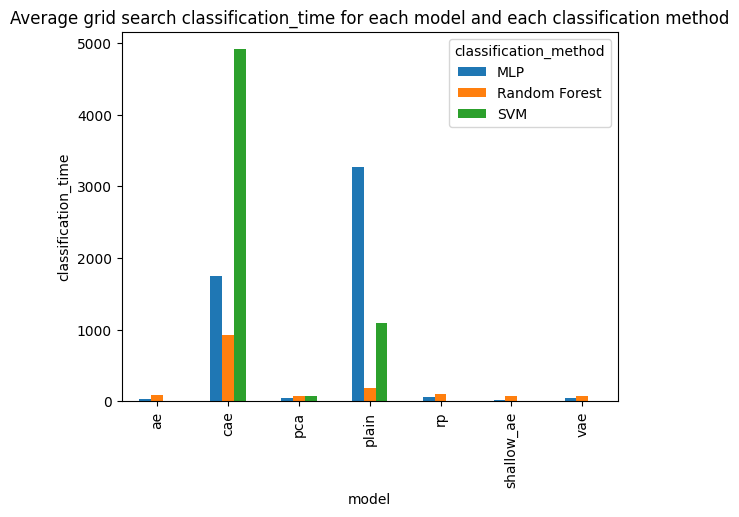

In [19]:
df.groupby(['model', 'classification_method'])['classification_time'].mean().unstack().plot(kind='bar')
plt.ylabel('classification_time')
plt.title('Average grid search classification_time for each model and each classification method')
plt.show()

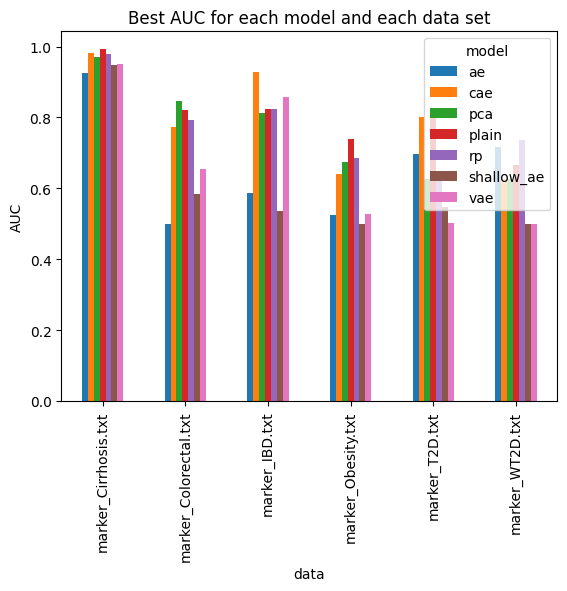

In [20]:
# compare each model best auc for each data set
df.groupby(['data', 'model'])['AUC'].max().unstack().plot(kind='bar')
plt.ylabel('AUC')
plt.title('Best AUC for each model and each data set')
plt.show()

# Discussion

The goal of the original paper was to find the best prediction method for each dataset, comparing their performance on each task (in particular, the authors of DeepMicro wanted to see whether autoencoders would have superior performance to traditional dimension reduction or classification-only techniques).

Below is a summary of DeepMicro's findings of the best methods, compared to ours.

| Dataset | DeepMicro Best Results | Our Best Results | Our Best Results (excluding Plain) |
|------|-------------------|-------------|-------------|
| Marker IBD | SAE/SVM; AUC=0.955   | CAE/RF; AUC=0.929 | CAE/RF; AUC=0.929   |
| Marker EW-T2D | SAE/RF; AUC=0.899   | RP/RF; AUC=0.737 | RP/RF; AUC=0.737   |
| Marker C-T2D | CAE/MLP; AUC=0.763 | Plain/MLP; AUC=0.807 | CAE/SVM; AUC=0.807 |
| Marker Obesity | DAE/RF; AUC=0.659 | Plain/RF; AUC=0.739 | RP/RF; AUC=0.685 |
| Marker Cirrhosis | CAE/SVM; AUC=0.940 | Plain/RF; AUC=0.992 | CAE/SVM; AUC=0.98 |
| Marker Colorectal | Plain/RF; AUC=0.811 | MLP/PCA; AUC=0.846 | MLP/PCA; AUC=0.846 |

In general, the findings of the original paper differ significantly from our own.

None of the original paper's most performant models perfectly replicated in our own study.  In all 6 marker datasets, the model we found that gave the best results was different than theirs;  in some cases, such as IBD, we measured worse performance (AUC=0.929 vs our AUC=0.955),  while in other cases, ours outperformed the original's, such as in the Cirrhosis dataset (AUC=0.940 vs our AUC=0.992).

Furthermore, while the original paper claimed that the DeepMicro (autoencoder-based) methods outperformed other classification methods in 5 out of 6 datasets, our conclusion was quite different:  in only 1 out of 5 datasets (Marker IBD) did we find that an autoencoder (in this case, CAE with RF classification) had superior results.

The original paper claimed that "none of the autoencoders dominate across the datasets in terms of getting the best representation for classification".  However, in our reproduction, we observed the CAE consistently outperformed the other 3 autoencoder methods in all of the datasets except for Marker EW-T2D.

The training time benchmarks of the original paper also diverged from ours slightly, but this is less worth discussing due to the fact that we ported our code over to pytorch and used different hardware settings for our training runs.  In general, we confirmed that MLP takes the longest to run with the plain method, followed by SVM, and then RF.

The orginal paper suggests repeating the entire training process for each method 5 times, then taking the average of the AUC to get the final result.  Due to the long training times for each dataset (roughly 5 hours each), this aspect was less practical.  Otherwise, most aspects of the paper were fairly easy to *attempt* to reproduce, given the extensive, existing codebase, though very little of the findings were able to be reproduced in actuality.

While the codebase itself was fairly well-organized and easy to run, the specific parameters of each experiment had to be reconstructed, as the original simply had a CLI that took dozens of arguments to configure each experiment.  It would have been more helpful if the paper also gave the exact arguments they gave when running each method.

Further studies might investigate the high variance and discrepency of the original findings.  For example, perhaps the datasets we found where the plain method had the highest AUC have something in common; further research could be done into what exactly this commonality is.

Our conclusion is that the central findings of the paper, namely that autoencoders consistently outperform other methods on microbiome data for disease prediction, are not necessarily reproducible.  In 3 out of 6 datasets, non-representation-learning-based "plain" methods outperformed all other methods we tested, while in 5 out of 6 datsets, non-autoencoder-based methods outperformed autoencoder-based methods.  

# References

1. Cho, I., & Blaser, M. J. (2012). The human microbiome: at the interface of health and disease. Nature Reviews Genetics, 13(4), 260-270.
2. Huttenhower, C. et al. Structure, function and diversity of the healthy human microbiome. nature 486, 207 (2012).
3. McQuade, J. L., Daniel, C. R., Helmink, B. A. & Wargo, J. A. Modulating the microbiome to improve therapeutic response in cancer. The Lancet Oncology 20, e77–e91 (2019).
4. Eloe-Fadrosh, E. A. & Rasko, D. A. The human microbiome: from symbiosis to pathogenesis. Annual review of medicine 64, 145–163 (2013).
5. Scholz, M. et al. Strain-level microbial epidemiology and population genomics from shotgun metagenomics. Nature methods 13, 435 (2016).
6. Truong, D. T. et al. MetaPhlAn2 for enhanced metagenomic taxonomic profiling. Nature methods 12, 902 (2015).
7. Oh, M., & Zhang, L. (2020). DeepMicro: deep representation learning for disease prediction based on microbiome data. Scientific reports, 10(1), 6026.
8. Pasolli, E., Truong, D. T., Malik, F., Waldron, L. & Segata, N. Machine learning meta-analysis of large metagenomic datasets: tools and biological insights. PLoS computational biology 12, e1004977 (2016).
9. Cawley, G. C. & Talbot, N. L. On over-fitting in model selection and subsequent selection bias in performance evaluation. Journal of Machine Learning Research 11, 2079–2107 (2010).
10. Varma, S. & Simon, R. Bias in error estimation when using cross-validation for model selection. BMC bioinformatics 7, 91 (2006).
